In [9]:
import json, os

guided_path = "/home/gridsan/jroney/solab/af3/FoldScaling/data/monomer_predictions_fk/boltz_results_monomers_fasta/predictions"
unguided_path = "/home/gridsan/jroney/solab/af3/FoldScaling/data/monomer_predictions_unguided/boltz_results_monomers_fasta/predictions"
codes = os.listdir(guided_path)

conf_unguided = {}
conf_guided = {}

for c in codes:
    conf_unguided[c] = [json.load(open(f'{unguided_path}/{c}/{p}','r'))['confidence_score'] for p in os.listdir(f'{unguided_path}/{c}') if p.endswith('json')]
    conf_guided[c] = [json.load(open(f'{guided_path}/{c}/{p}','r'))['confidence_score'] for p in os.listdir(f'{guided_path}/{c}') if p.endswith('json')]


In [38]:
import pickle
pickle.dump(conf_unguided, open("monomer_conf_unguided.pkl",'wb'))
pickle.dump(conf_guided, open("monomer_conf_guided.pkl", 'wb'))

In [1]:
import pickle
conf_guided = pickle.load(open("monomer_conf_guided.pkl", 'rb'))
conf_unguided = pickle.load(open("monomer_conf_unguided.pkl", 'rb'))
codes = list(conf_guided.keys())

In [2]:
import pandas as pd
tmscore_data = pd.read_csv("../tts_scripts/tm_scores.csv")

In [3]:
tm_guided = {}
tm_unguided = {}

for i,r in tmscore_data.iterrows():
    if r['source'] == 'fk':
        if r['code'] not in tm_guided:
            tm_guided[r['code']] = []
        tm_guided[r['code']].append((r['model_num'], r['tm_score']))
    else:
        if r['code'] not in tm_unguided:
            tm_unguided[r['code']] = []
        tm_unguided[r['code']].append((r['model_num'], r['tm_score']))

In [4]:
import numpy as np
max_guided = []
max_unguided = []

bootstrap_res_guided = np.zeros([len(codes), 32, 64])
bootstrap_res_unguided = np.zeros([len(codes), 32, 64])

import random
for i,c in enumerate(codes):
    for nfes in range(1,33):
        for r in range(64):
            bootstrap_res_guided[i,nfes-1,r] = max(random.choices(conf_guided[c], k=nfes))
            bootstrap_res_unguided[i,nfes-1,r] = max(random.choices(conf_unguided[c], k=nfes*8))

Text(0, 0.5, 'Best of 32 With 8-particle FK Steering')

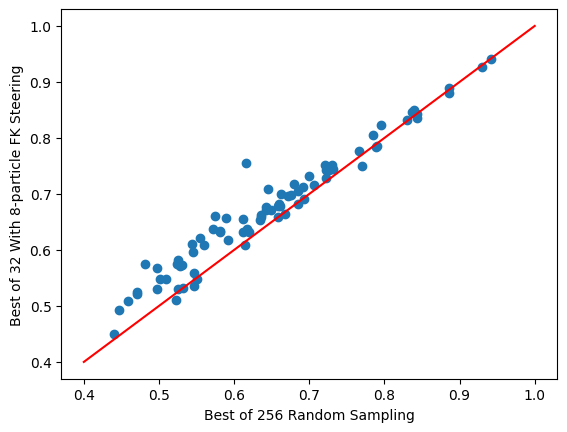

In [5]:
import matplotlib.pyplot as plt

plt.scatter(bootstrap_res_unguided[:,-1].mean(axis=-1), bootstrap_res_guided[:,-1].mean(axis=-1))
plt.plot([0.4,1], [0.4,1], color='red')
plt.xlabel("Best of 256 Random Sampling")
plt.ylabel("Best of 32 With 8-particle FK Steering")


In [11]:
print((bootstrap_res_unguided[:,-1].mean(axis=-1) < bootstrap_res_guided[:,-1].mean(axis=-1)).mean())
print((bootstrap_res_unguided[:,-1].mean(axis=-1) - bootstrap_res_guided[:,-1].mean(axis=-1)).mean())
print((bootstrap_res_unguided[:,-1].mean(axis=-1) - bootstrap_res_guided[:,-1].mean(axis=-1)).min())

0.8227848101265823
-0.02678046779282674
-0.13871960248798132


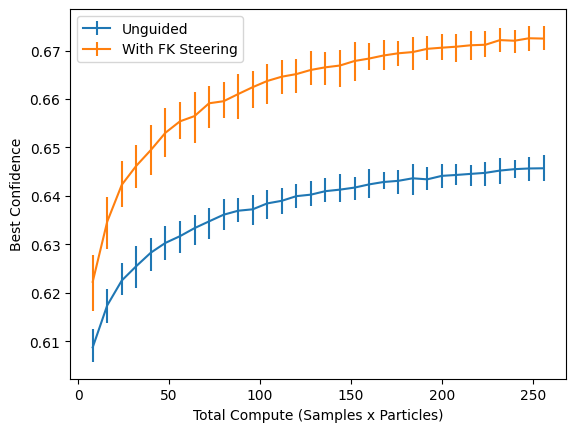

In [13]:
plt.errorbar([x*8 for x in range(1,33)], bootstrap_res_unguided.mean(axis=(0,-1)), np.vstack([bootstrap_res_unguided.mean(axis=(0,-1))-np.percentile(bootstrap_res_unguided.mean(axis=0), 2.5, axis=-1), np.percentile(bootstrap_res_unguided.mean(axis=0), 97.5, axis=-1)-bootstrap_res_unguided.mean(axis=(0,-1))]), label="Unguided")
plt.errorbar([x*8 for x in range(1,33)], bootstrap_res_guided.mean(axis=(0,-1)), np.vstack([bootstrap_res_guided.mean(axis=(0,-1))-np.percentile(bootstrap_res_guided.mean(axis=0), 2.5, axis=-1), np.percentile(bootstrap_res_guided.mean(axis=0), 97.5, axis=-1)-bootstrap_res_guided.mean(axis=(0,-1))]), label="With FK Steering")

plt.xlabel("Total Compute (Samples x Particles)")
plt.ylabel("Best Confidence")
plt.legend()



In [14]:
codes[(bootstrap_res_guided[:,-1].mean(axis=-1) - bootstrap_res_unguided[:,-1].mean(axis=-1)).argmax()]

'1i2t'

(array([38.81063687,  8.43709497,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  6.74967598]),
 array([0.57356745, 0.59208686, 0.61060627, 0.62912567, 0.64764508,
        0.66616449, 0.6846839 , 0.7032033 , 0.72172271, 0.74024212,
        0.75876153]),
 <BarContainer object of 10 artists>)

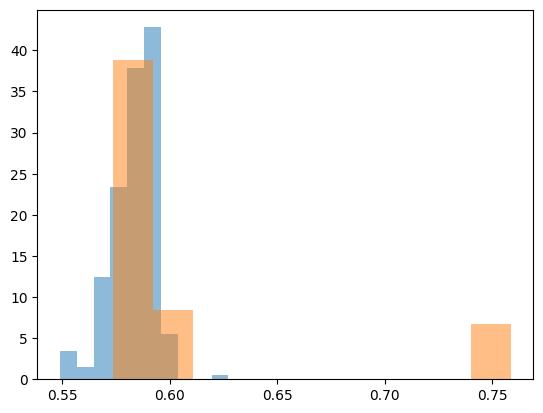

In [15]:
import matplotlib.pyplot as plt
plt.hist(conf_unguided['1i2t'], density=True, alpha=0.5)
plt.hist(conf_guided['1i2t'], density=True, alpha=0.5)

In [16]:
import numpy as np


bootstrap_tm_guided = np.zeros([len(tm_guided), 32, 64])
bootstrap_tm_unguided = np.zeros([len(tm_unguided), 32, 64])

import random
for i,c in enumerate(tm_guided.keys()):
    for nfes in range(1,33):
        for r in range(64):
            bootstrap_tm_guided[i,nfes-1,r] = min(random.choices(tm_guided[c], k=nfes), key=lambda x: x[0])[1]
            bootstrap_tm_unguided[i,nfes-1,r] = min(random.choices(tm_unguided[c], k=nfes*8), key=lambda x: x[0])[1]

Text(0.5, 1.0, 'Results for 1i2t')

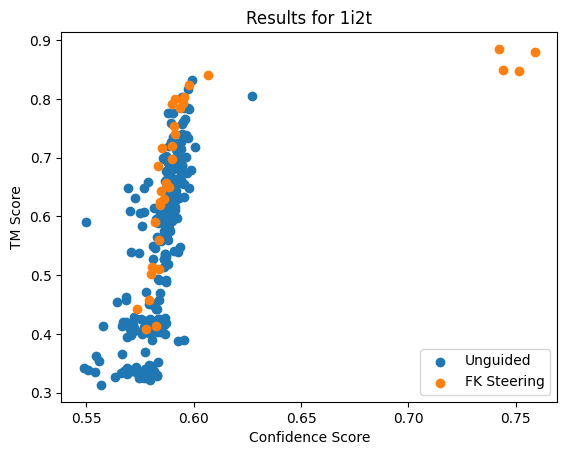

In [39]:
pdb = '1i2t'
plt.scatter([sorted(conf_unguided[pdb], reverse=True)[x[0]] for x in tm_unguided[pdb]], [x[1] for x in tm_unguided[pdb]], label="Unguided")
plt.scatter([sorted(conf_guided[pdb], reverse=True)[x[0]] for x in tm_guided[pdb]], [x[1] for x in tm_guided[pdb]], label="FK Steering")
plt.xlabel("Confidence Score")
plt.ylabel("TM Score")
plt.legend()
plt.title("Results for 1i2t")

Text(0.5, 1.0, 'Results for 2r2z')

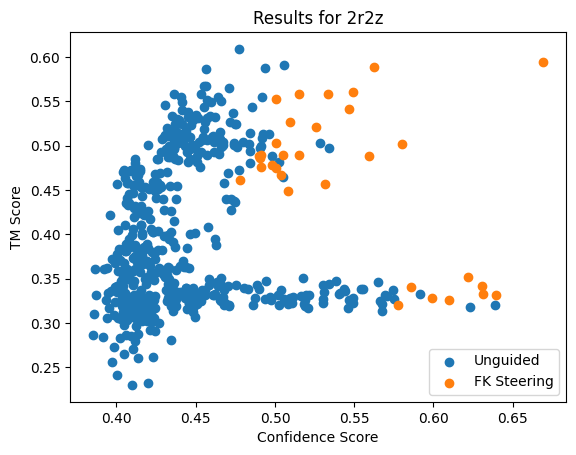

In [40]:
pdb = '2r2z'
plt.scatter([sorted(conf_unguided[pdb], reverse=True)[x[0]] for x in tm_unguided[pdb]], [x[1] for x in tm_unguided[pdb]], label="Unguided")
plt.scatter([sorted(conf_guided[pdb], reverse=True)[x[0]] for x in tm_guided[pdb]], [x[1] for x in tm_guided[pdb]], label="FK Steering")
plt.xlabel("Confidence Score")
plt.ylabel("TM Score")
plt.legend()
plt.title("Results for 2r2z")

Text(0, 0.5, 'Best of 32 TMscore -- 8-particle FK Steering')

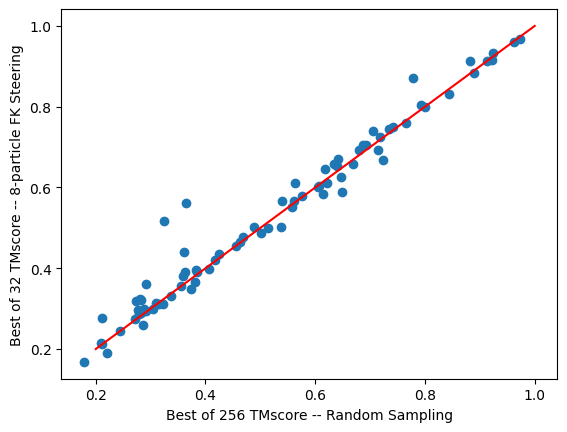

In [17]:
import matplotlib.pyplot as plt

plt.scatter(bootstrap_tm_unguided[:,-1].mean(axis=-1), bootstrap_tm_guided[:,-1].mean(axis=-1))
plt.plot([0.2,1], [0.2,1], color='red')
plt.xlabel("Best of 256 TMscore -- Random Sampling")
plt.ylabel("Best of 32 TMscore -- 8-particle FK Steering")


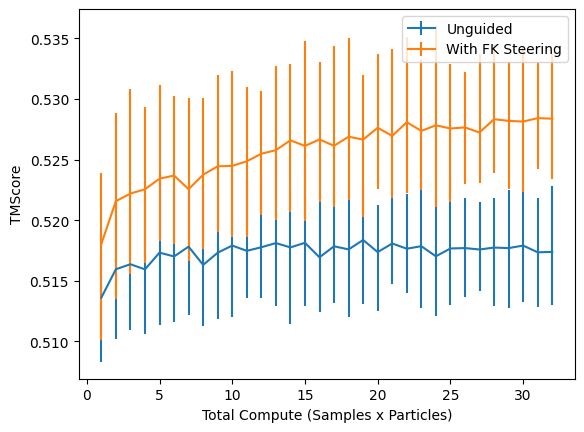

In [18]:
plt.errorbar(list(range(1,33)), bootstrap_tm_unguided.mean(axis=(0,-1)), np.vstack([bootstrap_tm_unguided.mean(axis=(0,-1))-np.percentile(bootstrap_tm_unguided.mean(axis=0), 2.5, axis=-1), np.percentile(bootstrap_tm_unguided.mean(axis=0), 97.5, axis=-1)-bootstrap_tm_unguided.mean(axis=(0,-1))]), label="Unguided")
plt.errorbar(list(range(1,33)), bootstrap_tm_guided.mean(axis=(0,-1)), np.vstack([bootstrap_tm_guided.mean(axis=(0,-1))-np.percentile(bootstrap_tm_guided.mean(axis=0), 2.5, axis=-1), np.percentile(bootstrap_tm_guided.mean(axis=0), 97.5, axis=-1)-bootstrap_tm_guided.mean(axis=(0,-1))]), label="With FK Steering")

plt.xlabel("Total Compute (Samples x Particles)")
plt.ylabel("TMScore")
plt.legend()

In [57]:
list(tm_guided.keys())[(bootstrap_tm_guided[:,-1].mean(axis=-1) - bootstrap_tm_unguided[:,-1].mean(axis=-1)).argmax()]

'2r2z'

(array([1.96829729, 1.31219819, 1.31219819, 1.31219819, 2.62439639,
        1.96829729, 2.62439639, 1.31219819, 3.28049549, 3.28049549]),
 array([0.4088 , 0.45643, 0.50406, 0.55169, 0.59932, 0.64695, 0.69458,
        0.74221, 0.78984, 0.83747, 0.8851 ]),
 <BarContainer object of 10 artists>)

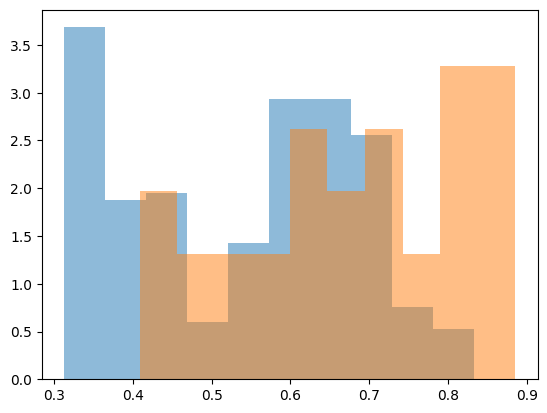

In [29]:
import matplotlib.pyplot as plt
plt.hist([x[1] for x in tm_unguided['1i2t']], density=True, alpha=0.5)
plt.hist([x[1] for x in tm_guided['1i2t']], density=True, alpha=0.5)

(array([12.48098136,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 25.55629517]),
 array([0.3313 , 0.35759, 0.38388, 0.41017, 0.43646, 0.46275, 0.48904,
        0.51533, 0.54162, 0.56791, 0.5942 ]),
 <BarContainer object of 10 artists>)

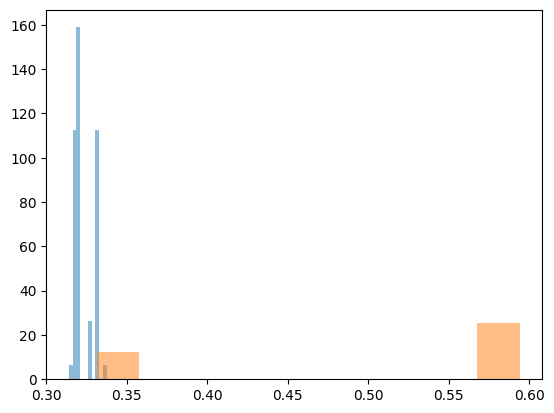

In [63]:
plt.hist(bootstrap_tm_unguided[47,-1], density=True, alpha=0.5)
plt.hist(bootstrap_tm_guided[47,-1], density=True, alpha=0.5)